In [1]:
library(Seurat)
library(SCP)
library(ggplot2)
library(dplyr)
library(Trex)    
library(harmony)
library(SummarizedExperiment)
library(scater)

load("data/cycle.rda")
source('helpers2.r')

set.seed(123)

root.dir <- "/project/bicistronic_carT_gbm_Jackie/"
figures.dir <- paste0(root.dir, "Figures/")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




Conda not found.

If you have already created an SCP python environment using conda, you can specify the conda path by setting options(reticulate.conda_binary = "/path/to/conda", SCP_env_name = "SCP_env") before loading the package.


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
  

# Pre-processing of CSF object

In [2]:
prepost <- readRDS(paste0(root.dir, "ProcessedData/seurat/annotated_prepost_csf_original.rds")) # this is the older version of csf Seurat object

In [3]:
myeloid <- subset(prepost, cell_type %in% c('Mono_Macs','TAMs','cDC1','cDC2','mDC','pDC'))

In [4]:
myeloid <- preprocess_seurat_object(myeloid, g2m_genes, s_genes, nfeatures = 4000, phase_threshold = 1)
myeloid <- RunHarmony(myeloid, 'Batch', verbose = FALSE)
myeloid <- FindNeighbors(myeloid, reduction = "harmony", dims = 1:50)
myeloid <- FindClusters(myeloid, resolution = .5, cluster.name = "harmony_clusters", algorithm = 1)
myeloid <- RunUMAP(myeloid, reduction = "harmony", dims = 1:50, verbose=F, reduction.name = "umap.harmony", 
                   spread=1, min.dist=.5, n.neighbors = 40, metric='cosine')

Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Centering and scaling data matrix

PC_ 1 
Positive:  RHEX, CLEC4C, NIBAN3, GZMB, PTPRS, ZFAT, BCL11A, JCHAIN, AC023590.1, CUX2 
	   MZB1, COL24A1, PACSIN1, EPHB1, RUNX2, CARD11

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12863
Number of edges: 513482

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9105
Number of communities: 15
Elapsed time: 1 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


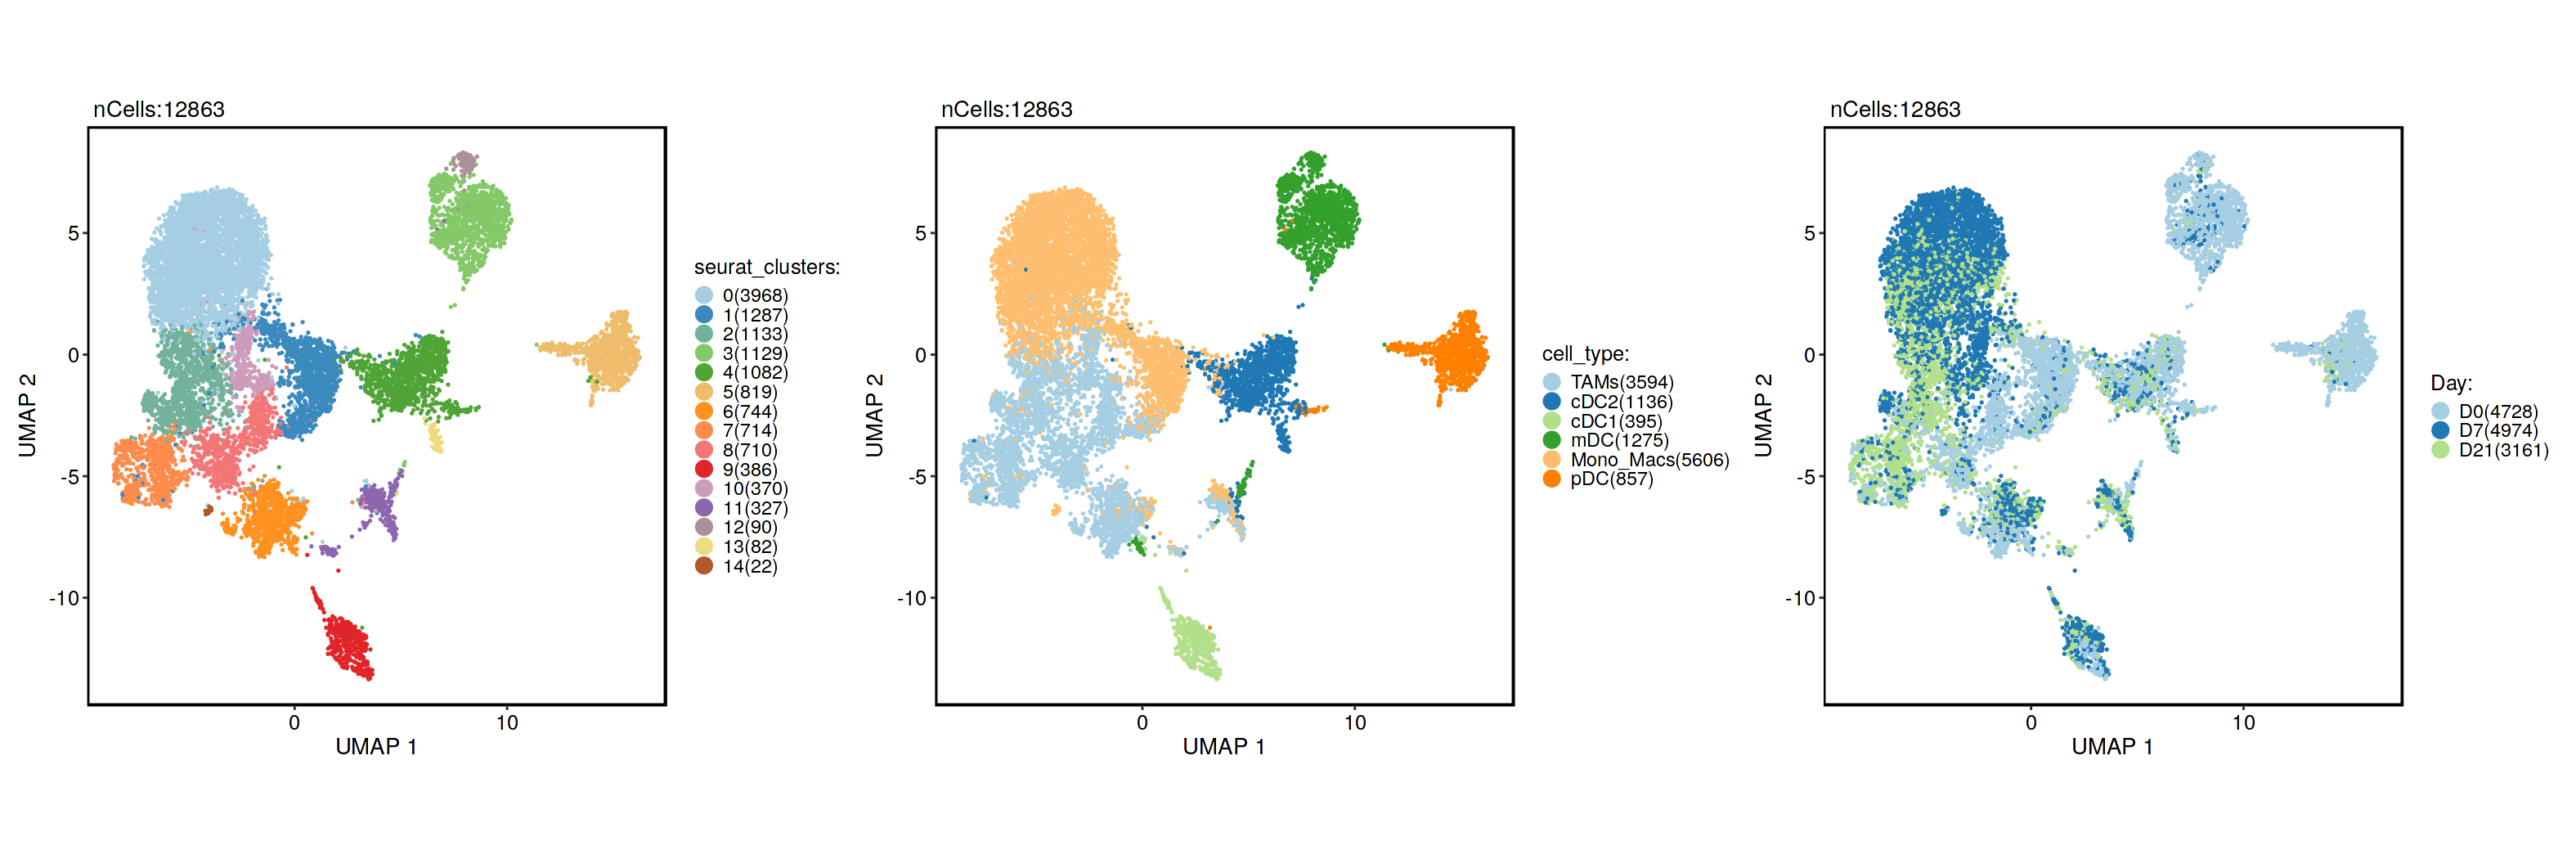

In [5]:
options(repr.plot.width = 21, repr.plot.height = 7, repr.plot.res=150)
CellDimPlot(myeloid, reduction='umap.harmony', group.by = c("seurat_clusters","cell_type", "Day"), pt.size=.2, ncol=3)  & 
    xlab('UMAP 1')  & ylab('UMAP 2')

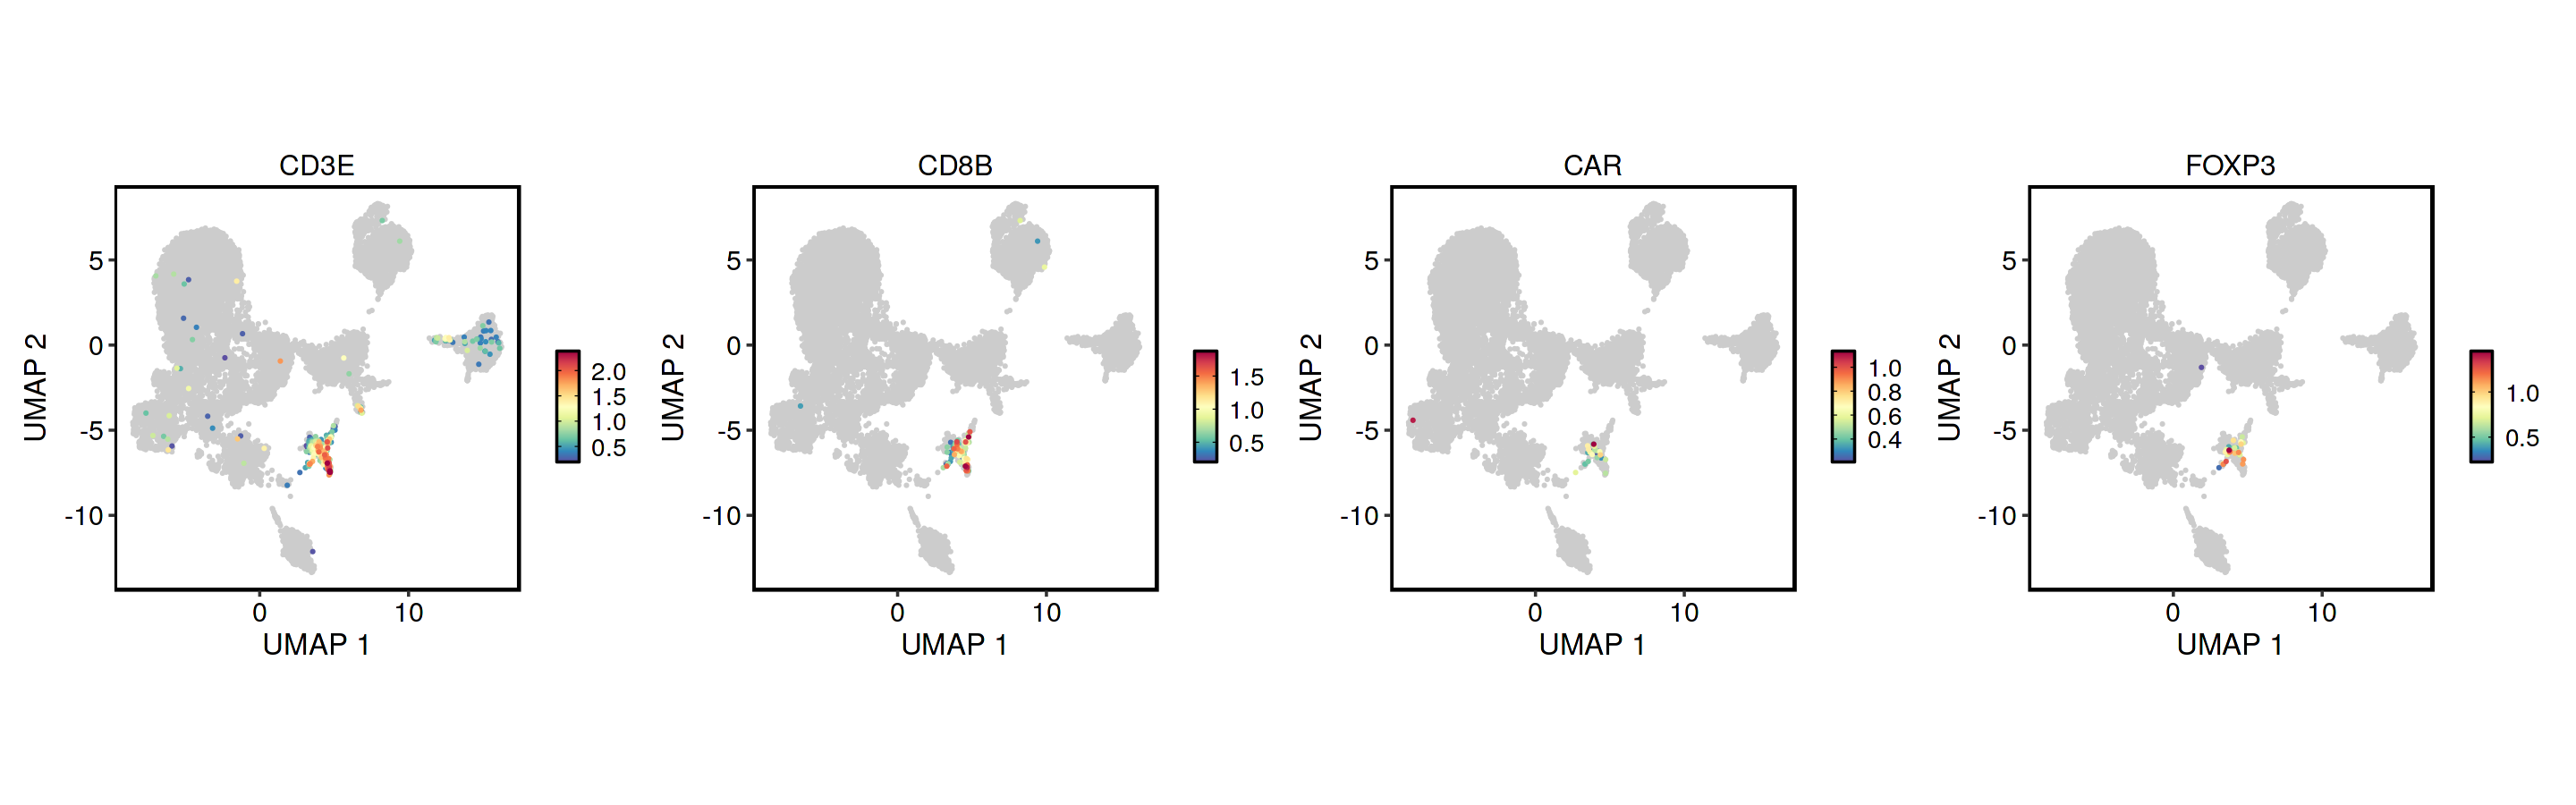

In [6]:
options(repr.plot.width = 16, repr.plot.height = 5, repr.plot.res=180)
FeatureDimPlot(myeloid, features=c('CD3E','CD8B','CAR','FOXP3'), 
               ncol=4,reduction = "umap.harmony", show_stat=F, bg_cutoff=0,
               label = F, pt.size=0.2) & xlab('UMAP 1') & ylab('UMAP 2')

In [7]:
# remove non-myeloid cells
myeloid <- subset(myeloid, harmony_clusters %!in% c(11,14))

In [8]:
# re-cluster
myeloid <- FindNeighbors(myeloid, reduction = "harmony", dims = 1:30)
myeloid <- FindClusters(myeloid, resolution = .3, cluster.name = "harmony_clusters", algorithm = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12514
Number of edges: 471783

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9346
Number of communities: 10
Elapsed time: 1 seconds


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


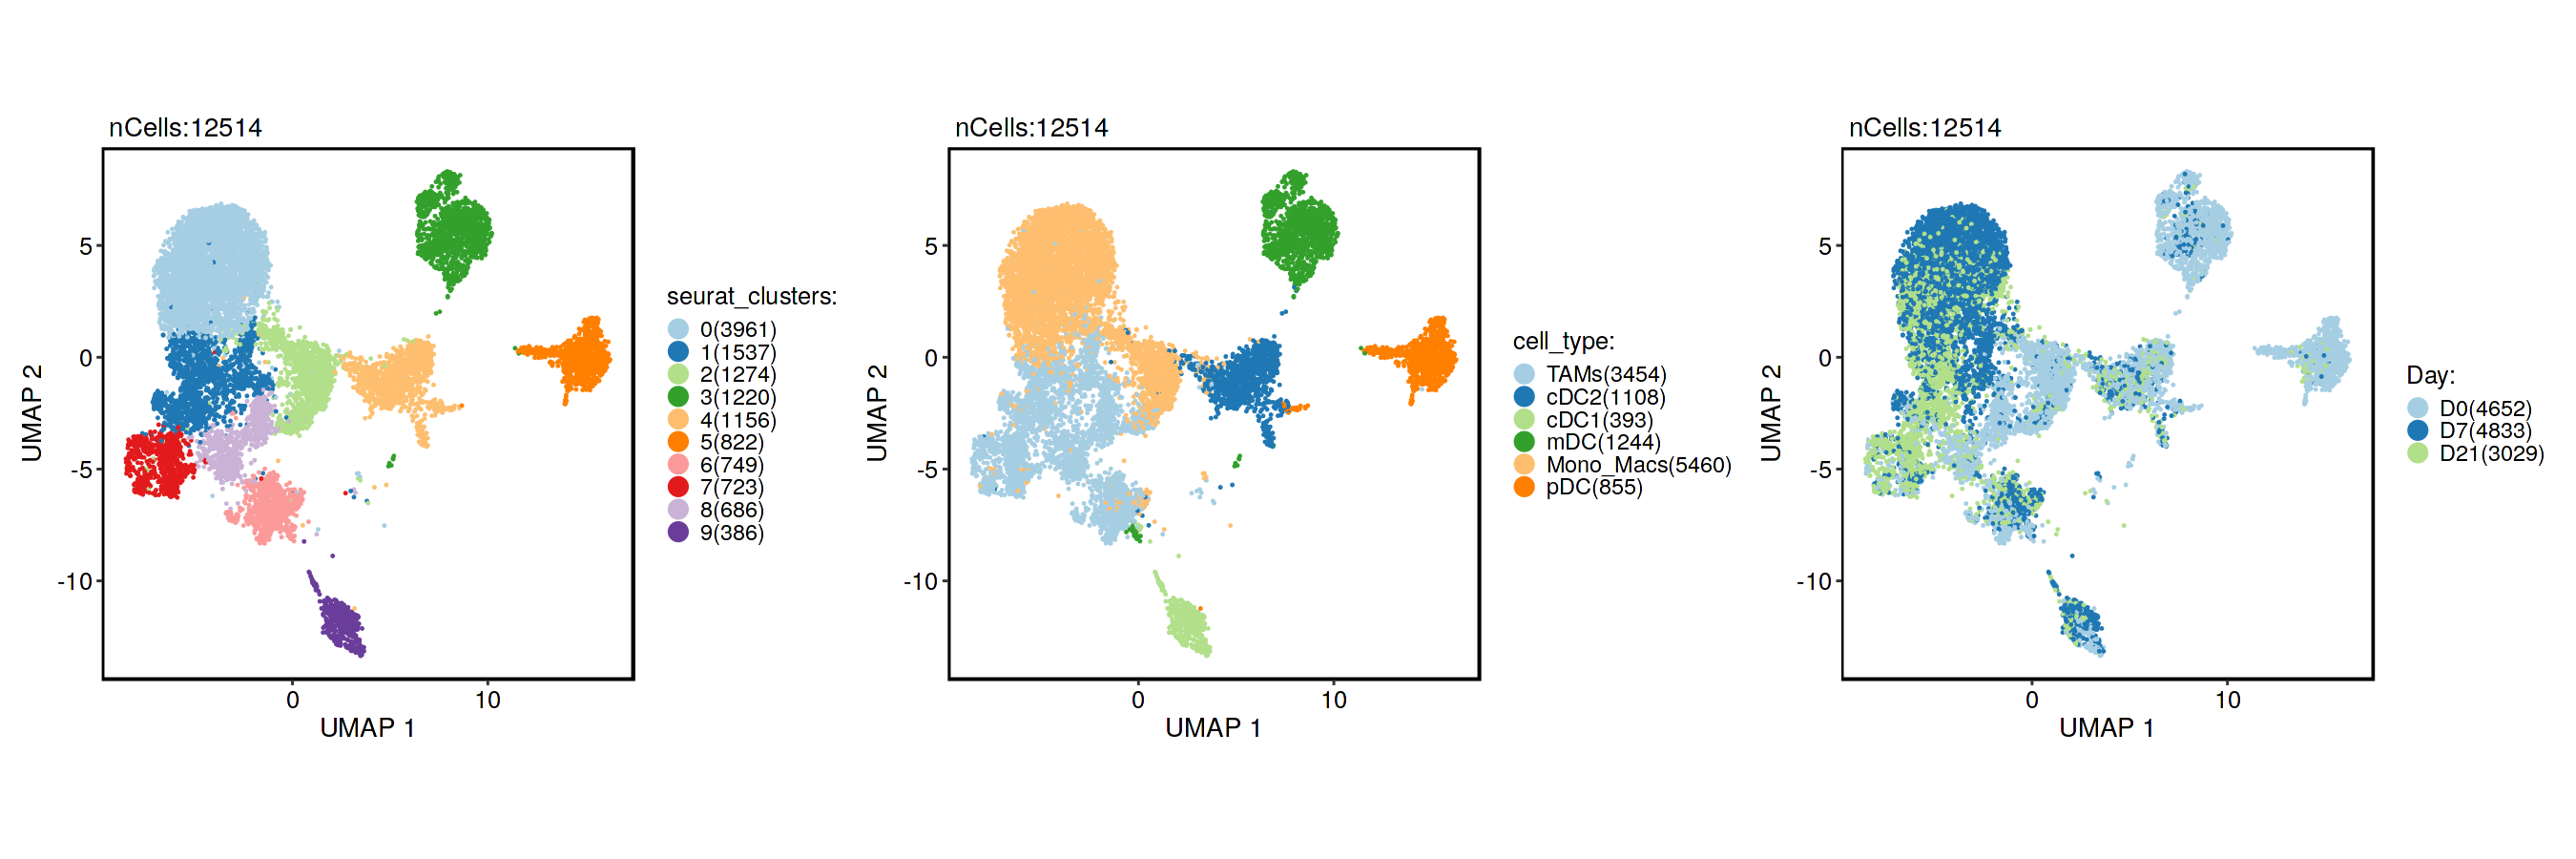

In [9]:
options(repr.plot.width = 18, repr.plot.height = 6, repr.plot.res=150)
CellDimPlot(myeloid, reduction='umap.harmony', group.by = c("seurat_clusters", "cell_type", "Day"), pt.size=.1, ncol=3)  & 
    xlab('UMAP 1')  & ylab('UMAP 2')

In [10]:
# update cell types by cluster
Idents(myeloid) <- myeloid$seurat_clusters
myeloid <- RenameIdents(myeloid, 
       "0" = "1. Monocytes",
       "1" = "2. Macrophages",
       "2" = "3. Monocytes",
       "3" = "mregDC",
       "4" = "cDC2",
       "5" = "pDC",
       "6" = "4. Macrophages", 
       "7" = "5. Macrophages", 
       "8" = "6. Macrophages",
       "9" = "cDC1"
)
myeloid$cell_type_level1_clust <- Idents(myeloid)

In [11]:
Idents(myeloid) <- myeloid$seurat_clusters
myeloid <- RenameIdents(myeloid, 
       "0" = "Monocytes",
       "1" = "Macrophages",
       "2" = "Monocytes",
       "3" = "mregDC",
       "4" = "cDC2",
       "5" = "pDC",
       "6" = "Macrophages", 
       "7" = "Macrophages", 
       "8" = "Macrophages",
       "9" = "cDC1"
)
myeloid$cell_type_level1 <- Idents(myeloid)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


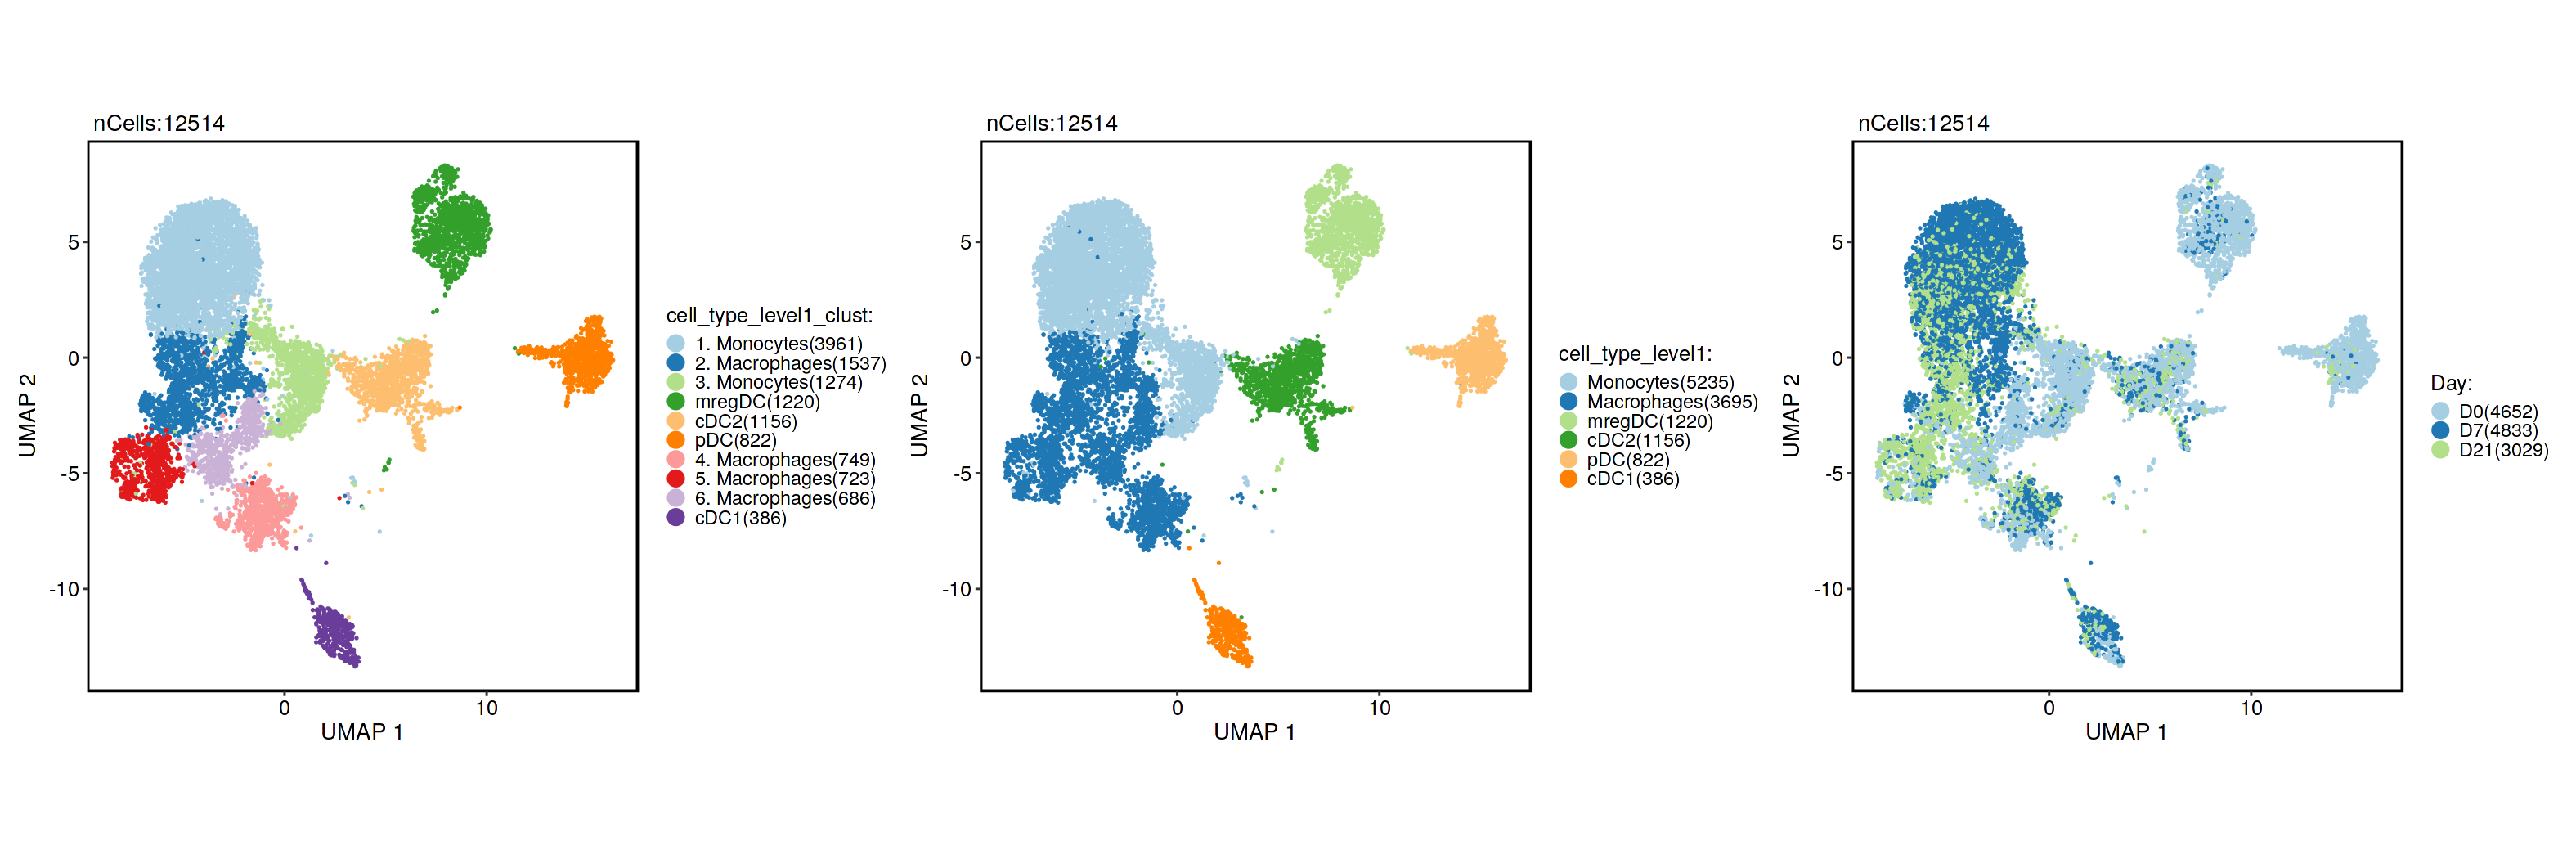

In [12]:
options(repr.plot.width = 21, repr.plot.height = 7, repr.plot.res=150)
CellDimPlot(myeloid, reduction='umap.harmony', group.by = c("cell_type_level1_clust", "cell_type_level1", "Day"), pt.size=.2, ncol=3)  & 
    xlab('UMAP 1')  & ylab('UMAP 2')

# Refine monocyte and macrophage subclusters

In [13]:
monomacs <- subset(myeloid, cell_type_level1 %in% c('Monocytes','Macrophages'))

In [14]:
monomacs <- preprocess_seurat_object(monomacs,  g2m_genes, s_genes, nfeatures = 4000, phase_threshold = 1)
monomacs <- RunHarmony(monomacs, 'Batch', verbose = FALSE)
monomacs <- FindNeighbors(monomacs, reduction = "harmony", dims = 1:30)
monomacs <- FindClusters(monomacs, resolution = .7, cluster.name = "harmony_clusters", algorithm = 1)
monomacs <- RunUMAP(monomacs, reduction = "harmony", dims = 1:30, verbose=F, reduction.name = "umap.harmony", 
                spread=1, min.dist=.5, n.neighbors = 10, metric='cosine')

Centering and scaling data matrix

PC_ 1 
Positive:  SLC1A3, BMP2K, TCF4, FRMD4A, ST6GAL1, LNCAROD, NEAT1, SFMBT2, FRMD4B, PEAK1 
	   ZFHX3, ARHGAP22, FCHO2, DST, LDLRAD4, LRMDA, FGD4, SNX9, STARD13, TCF12 
	   MERTK, SLCO2B1, ABCA1, EPB41L2, ITSN1, ARID5B, ELMO1, OSBPL3, MYO5A, NRP2 
Negative:  PSME2, PSMB9, MCEMP1, TXN, IFITM3, PLAAT4, GBP1, TNFSF10, LY6E, GBP5 
	   CALHM6, NCF1, STAC, VAMP5, ISG15, PIM1, GBP4, IFIT3, IFITM2, SOCS1 
	   ICAM3, IFITM1, CD52, ENO1, FPR2, NEXN, LDHA, APOL4, TAP1, LSP1 
PC_ 2 
Positive:  LRRK2, SIK3, CREB5, JAK2, RUNX1, SMCHD1, MEGF9, RIPOR2, ARHGAP26, SLCO3A1 
	   LYST, SLC8A1, TMEM131L, GNAQ, EXT1, DDX60L, SIPA1L1, ST6GALNAC3, TNFSF10, DLEU2 
	   PLXDC2, FOXP1, AOAH, FOXN3, KDM7A, BANK1, CD55, MCTP1, TANK, TMEM154 
Negative:  APOC1, APOE, A2M, GPNMB, NUPR1, TREM2, C1QB, C1QC, CD59, PTMS 
	   PRDX1, MS4A4A, CSTB, DAB2, AKR1B1, LGMN, SELENOP, GPX3, PLD3, VAT1 
	   FABP5, FABP3, ACE, SLC1A3, PLA2G7, PRXL2A, VEGFB, PMP22, GPR34, MAF 
PC_ 3 
Positive:  MMP9

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8930
Number of edges: 341131

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8501
Number of communities: 13
Elapsed time: 0 seconds


In [15]:
# function for adding module score and then correcting the metadata column names (removes extra digits)
add.module.score <- function(seurat.obj, gene.signatures) {

  # remove existing  
  for (g in names(gene.signatures)) {
    if (g %in% colnames(seurat.obj@meta.data)) {
        seurat.obj@meta.data[[g]] <- NULL
    }
  }
    
  seurat.obj <- AddModuleScore(
    object = seurat.obj,
    features = gene.signatures,
    name = names(gene.signatures),
    search = T
  )
  
  i <- 1
  for (g in names(gene.signatures)) {
    colnames(seurat.obj@meta.data) <- gsub(paste0(g, i), g, colnames(seurat.obj@meta.data))
    i <- i + 1
  }
  
  return(seurat.obj)
}

In [16]:
# add Tyler Miller programs from the following paper:
# Miller, T. E. et al. Programs, origins and immunomodulatory functions of myeloid cells in glioma. Nature 640, 1072–1082 (2025).
miller.programs <- read.csv(paste0(root.dir, "Resources/", "Tyler_Myeloid_Programs.csv"))

gene.signatures <- list()

for (col in colnames(miller.programs)) {
    gene.signatures[[col]] <- miller.programs[[col]]
}

monomacs <- add.module.score(monomacs, gene.signatures)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


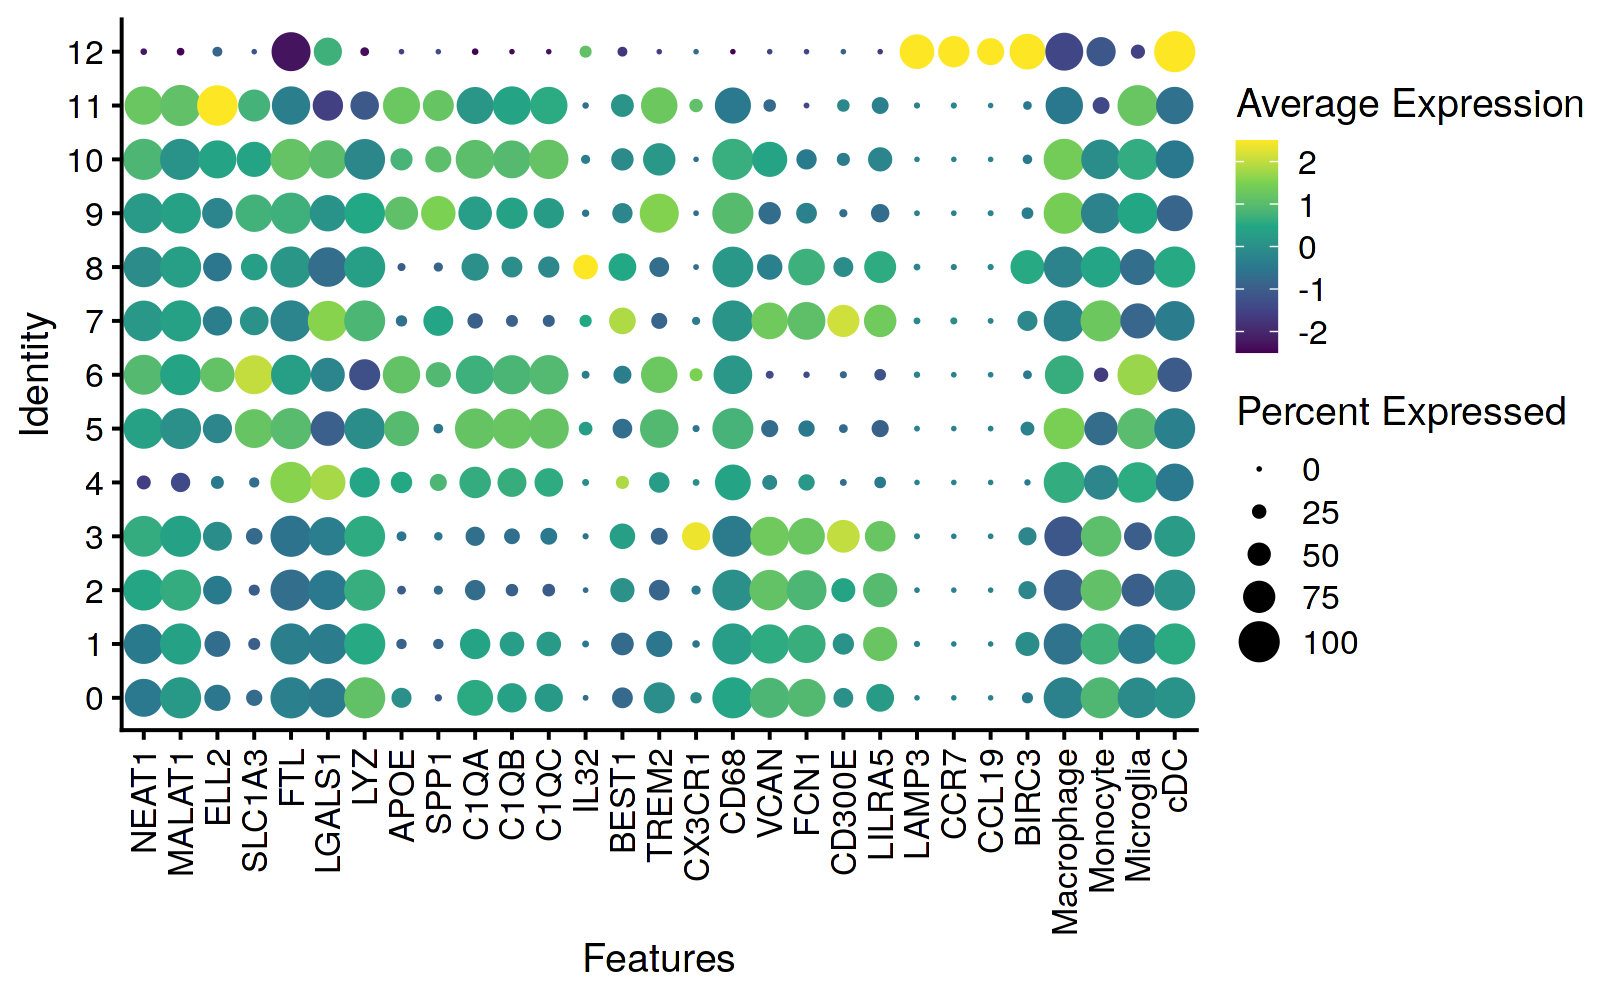

In [17]:
# visualize signatures
macrophage.subtype.genes <- c("NEAT1", "MALAT1", "ELL2", "SLC1A3", 
                               "FTL", "LGALS1", "LYZ",
                               "APOE", "SPP1", "C1QA", "C1QB", "C1QC",
                               "IL32", "BEST1", "TREM2", "CX3CR1", "CD68",
                               "VCAN", "FCN1", "CD300E", "LILRA5",
                               "LAMP3","CCR7", "CCL19", "BIRC3" # mregdc
                              )

other.signatures <- c("Macrophage", "Monocyte", "Microglia", "cDC")

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res=200)
DotPlot(monomacs, c(macrophage.subtype.genes, other.signatures), group.by = "seurat_clusters") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    scale_color_viridis_c(option = "D")

In [18]:
cell_type_level2 <- sapply(monomacs$seurat_clusters, function(x) {
    case_when(
        x %in% c(0, 1, 2) ~ "Monocyte",
        x %in% c(4, 5, 6, 9, 10, 11) ~ "Inhibitory macrophage",
        x %in% c(7, 8) ~ "Pro-inflammatory macrophage",
        x == 3 ~ "CX3CR1+ monocyte",
        x == 12 ~ "mregDC",
        TRUE ~ NA
    )
}) 

myeloid <- AddMetaData(myeloid, cell_type_level2, col.name = "cell_type_level2")
myeloid$cell_type <- apply(myeloid@meta.data, 1, function(row) ifelse(is.na(row[["cell_type_level2"]]), row[["cell_type_level1"]], row[["cell_type_level2"]]))

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


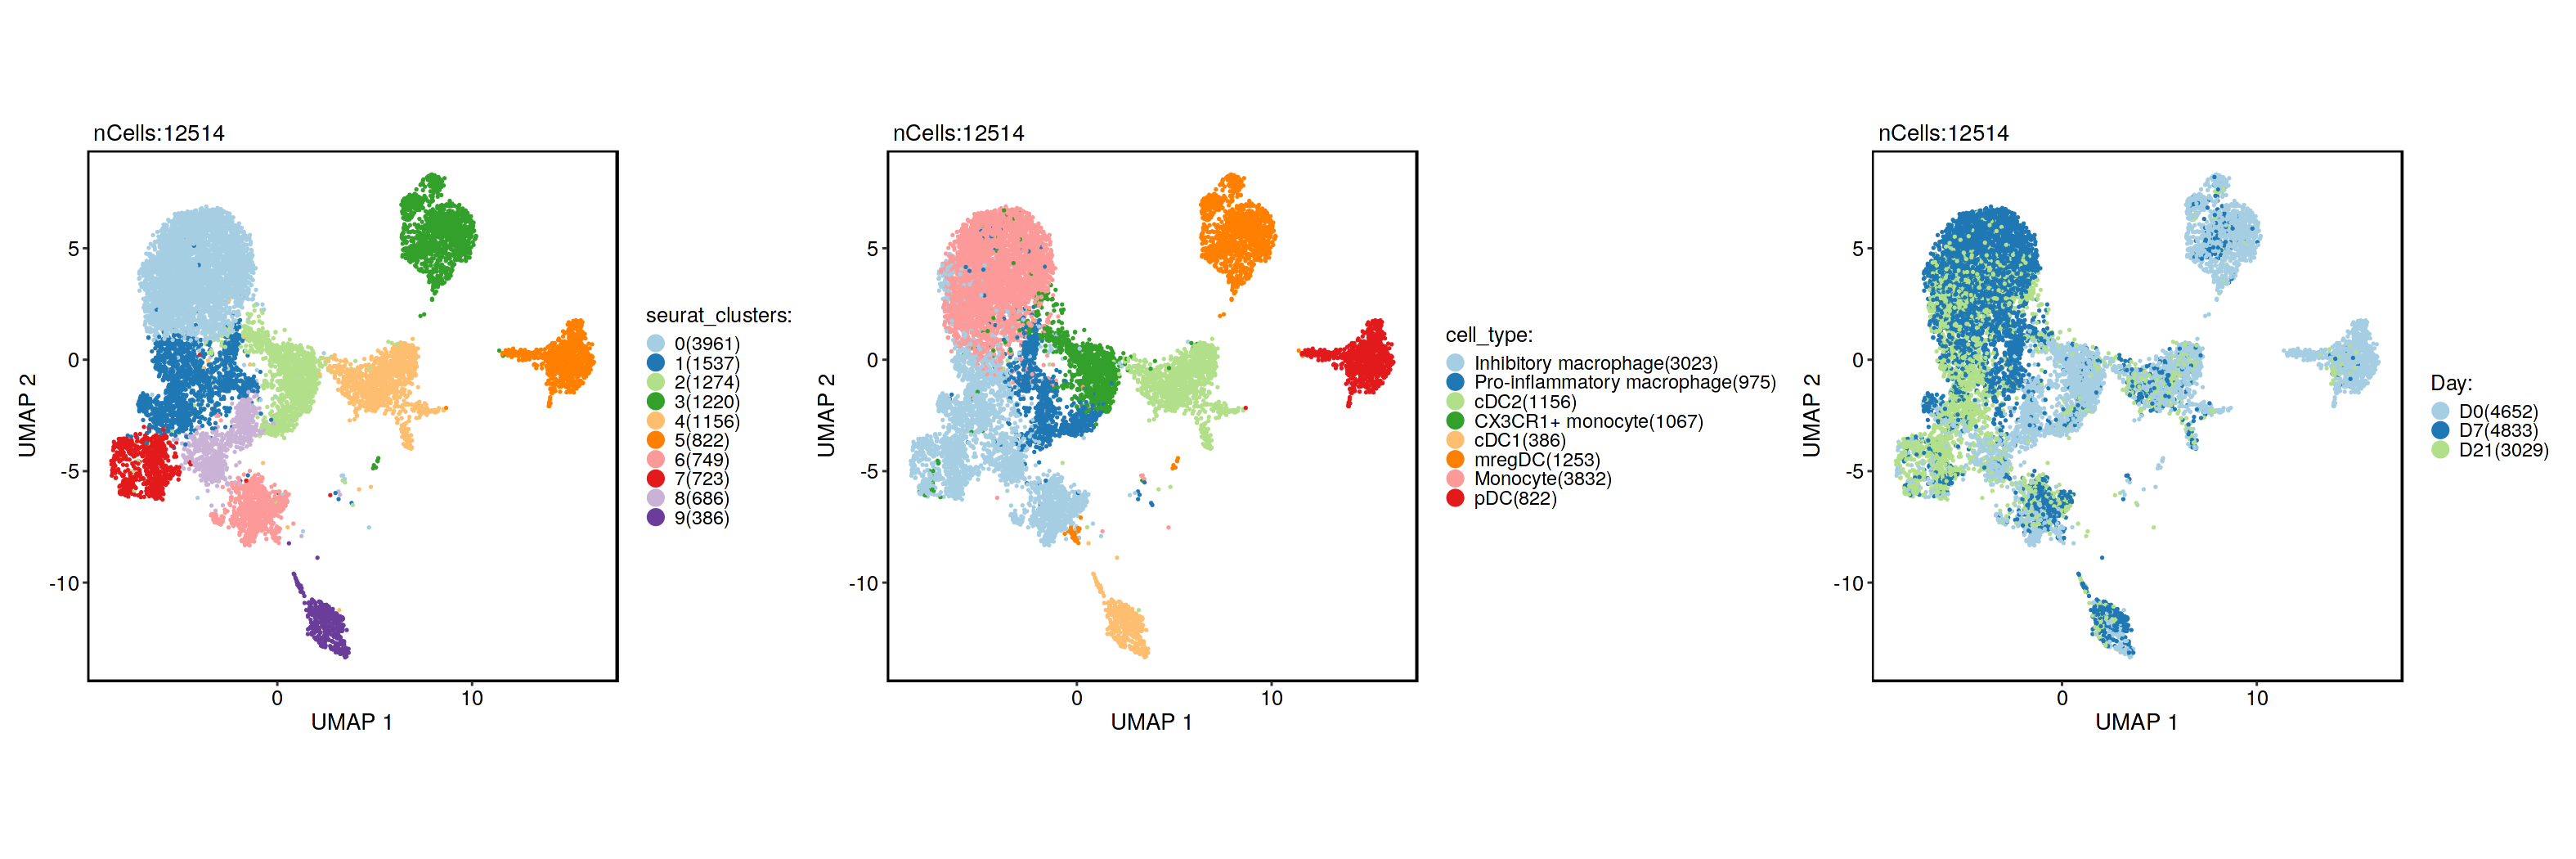

In [19]:
options(repr.plot.width = 21, repr.plot.height = 7, repr.plot.res=150)
CellDimPlot(myeloid, reduction='umap.harmony', group.by = c("seurat_clusters", "cell_type", "Day"), pt.size=.2, ncol=3) & 
    xlab('UMAP 1') & ylab('UMAP 2')

In [20]:
# combine P5D0 runs
myeloid$sample_id <- sapply(myeloid$sample_id, function(x) ifelse(x == "P5D0_run2", "P5D0", x))
myeloid$Day <- factor(myeloid$Day, levels = c("D0", "D7", "D21"))

In [21]:
# save myeloid object
saveRDS(myeloid, paste0(root.dir, "ProcessedData/seurat/annotated_myeloid_refined.rds"))    

In [22]:
# update csf Seurat object
prepost <- AddMetaData(prepost, myeloid$cell_type, col.name = "cell_type_myeloid")
prepost$cell_type <- apply(prepost@meta.data, 1, function(row) ifelse(is.na(row[["cell_type_myeloid"]]), row[["cell_type"]], row[["cell_type_myeloid"]]))
prepost$sample_id <- sapply(prepost$sample_id, function(x) ifelse(x == "P5D0_run2", "P5D0", x))
saveRDS(prepost, paste0(root.dir, "ProcessedData/seurat/annotated_prepost_csf_refined.rds"))

In [23]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-unknown-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/aarch64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/aarch64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.40.0               purrr_1.0.4                
 [3] tidyr_1.3.1                 scater_1.30.1              
 [5] scuttle_1.12.0       